In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 27.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    

In [2]:
!pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 26.6 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=10d5af24fe16b82a4921e0d46801850bde1c084a688fedb625120b6d0c64c279
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import requests as rq

from io import BytesIO


tf.get_logger().setLevel('ERROR')

In [4]:
url1 = "https://github.com/Taichi22/CollegeCode/raw/main/CSE480/NIHMS1911044-supplement-1%20(2).xlsx"
data = rq.get(url1).content
df_1 = pd.read_excel(BytesIO(data), header=1)
url2 = "https://github.com/Taichi22/CollegeCode/raw/main/CSE480/NIHMS1911044-supplement-2.csv"
data = rq.get(url2).content
ai_generated = pd.read_csv(BytesIO(data))

In [5]:
original_papers = pd.concat([df_1['Number'],df_1['File Name'], df_1['Column1'].str.split('\n', expand=True)], axis=1).copy()
original_papers.columns = original_papers.columns.map(str)
# Assuming original_papers is your DataFrame with 'Key' and paragraph columns.

# Melt the DataFrame to stack all paragraph columns into single column rows
melted_df = pd.melt(original_papers, id_vars=['File Name'], value_vars=[str(i) for i in range(0,17)])
melted_df = melted_df[melted_df['value'].notna()]
# melted_df.sort_values(by=["Unnamed: 0", 'variable'], inplace=True)
melted_df['Label'] = 0
melted_df.head(15)
print(len(melted_df))

961


In [6]:
ai_generated.head(20)
ai_generated['value'] = pd.Series(ai_generated[[str(i) for i in range(1,300)]].fillna('').values.tolist()).str.join(' ')
ai_generated["Label"] = [1 for i in range(len(ai_generated))]
ai_generated.head(20)

,Unnamed: 0,Key,1,2,3,4,5,6,7,8,...,293,294,295,296,297,298,299,300,value,Label
0,1,SciPer01GPH,Gonadotropin-releasing,hormone,(GnRH),is,a,neuropeptide,that,plays,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gonadotropin-releasing hormone (GnRH) is a neu...,1
1,2,SciPer01GPH,Animal,studies,have,provided,evidence,that,GnRH,can,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Animal studies have provided evidence that GnR...,1
2,3,SciPer01GPH,There,is,also,evidence,from,human,studies,that,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,There is also evidence from human studies that...,1
3,4,SciPer01GPH,The,mechanisms,by,which,GnRH,may,improve,cognitive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The mechanisms by which GnRH may improve cogni...,1
4,5,SciPer01GPH,"Overall,",the,research,on,GnRH,and,cognition,is,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Overall, the research on GnRH and cognition is...",1
5,6,SciPer01GPT,"Cognition,",the,mental,process,of,acquiring,knowledge,and,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cognition, the mental process of acquiring kno...",1
6,7,SciPer01GPT,One,hormone,that,has,received,considerable,attention,in,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,One hormone that has received considerable att...,1
7,8,SciPer01GPT,Another,hormone,that,has,been,investigated,for,its,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Another hormone that has been investigated for...,1
8,9,SciPer01GPT,Studies,have,also,investigated,the,potential,of,testosterone,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Studies have also investigated the potential o...,1
9,10,SciPer01GPT,While,the,potential,of,these,hormones,for,boosting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,While the potential of these hormones for boos...,1


In [7]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [8]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [9]:
text_test =[ai_generated['value'][0]]
print(text_test)
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

['Gonadotropin-releasing hormone (GnRH) is a neuropeptide that plays a key role in the regulation of reproductive function. However, recent studies have suggested that GnRH may also have a positive effect on cognitive function. Research has shown that GnRH receptors are present in regions of the brain that are involved in cognitive processing, including the hippocampus, amygdala, and prefrontal cortex.                                                                                                                                                                                                                                                ']
Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  2175 25389  4140 18981  2378  1011  8287 18714  1006  1043 16118]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
ai_text = ai_generated[["Label", "value"]]
ai_text = tf.data.Dataset.from_tensor_slices(dict(ai_text))
for feature_batch in ai_text.take(1):
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))
BERT_all_text = pd.concat([ai_generated[["Label", "value"]], melted_df[['Label', "value"]]])
BERT_all_text.head(20)

  'Label'             : 1
  'value'             : b'Gonadotropin-releasing hormone (GnRH) is a neuropeptide that plays a key role in the regulation of reproductive function. However, recent studies have suggested that GnRH may also have a positive effect on cognitive function. Research has shown that GnRH receptors are present in regions of the brain that are involved in cognitive processing, including the hippocampus, amygdala, and prefrontal cortex.                                                                                                                                                                                                                                                '


,Label,value
0,1,Gonadotropin-releasing hormone (GnRH) is a neu...
1,1,Animal studies have provided evidence that GnR...
2,1,There is also evidence from human studies that...
3,1,The mechanisms by which GnRH may improve cogni...
4,1,"Overall, the research on GnRH and cognition is..."
5,1,"Cognition, the mental process of acquiring kno..."
6,1,One hormone that has received considerable att...
7,1,Another hormone that has been investigated for...
8,1,Studies have also investigated the potential o...
9,1,While the potential of these hormones for boos...


In [11]:
BERT_train, BERT_test = train_test_split(BERT_all_text, stratify = BERT_all_text["Label"], test_size=0.2, random_state=42)
BERT_train, BERT_val = train_test_split(BERT_train, stratify = BERT_train["Label"], test_size=0.1, random_state=42)
print(BERT_train)
print(BERT_test)
print(BERT_val)

      Label                                              value
204       1  The Hawaii Volcano Observatory (HVO) closely ...
143       1  In conclusion, the Bengal Water Machine (BWM) ...
1130      0  The computational requirements also increase f...
627       0  Daly et al. and Cantuti-Castelvetri et al. fou...
181       0  Influenza viruses are an ever-constant public ...
...     ...                                                ...
191       1  Saturn's Rings:                               ...
272       1  Treatment for post-viral syndrome typically in...
906       0  Much remains to be discovered before scientist...
246       1  Flower color evolution is a complex process th...
924       0  There have also been recent changes in the dem...

[1233 rows x 2 columns]
     Label                                              value
459      1  The GaLM-polymer composite is made up of galli...
228      1  In conclusion, managing sources of error durin...
101      0  How organisms are opt

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 8
seed = 12

raw_train_ds = tf.data.Dataset.from_tensor_slices((BERT_train[["value"]], BERT_train[["Label"]]))
raw_train_ds.batch(batch_size)
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
print(train_ds)
raw_val_ds = tf.data.Dataset.from_tensor_slices((BERT_val[["value"]], BERT_val[["Label"]]))
raw_val_ds.batch(batch_size)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_test_ds = tf.data.Dataset.from_tensor_slices((BERT_test[["value"]], BERT_test[["Label"]]))
raw_test_ds.batch(batch_size)
test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.string, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='value')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [14]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 value (InputLayer)          [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_word_ids': (None,    0         ['value[0][0]']               
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [15]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [16]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [17]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [18]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
1233/1233 [==============================] - 51s 33ms/step - loss: 0.3050 - binary_accuracy: 0.8873 - val_loss: 0.1463 - val_binary_accuracy: 0.9708
Epoch 2/5
1233/1233 [==============================] - 42s 34ms/step - loss: 0.0885 - binary_accuracy: 0.9846 - val_loss: 0.1405 - val_binary_accuracy: 0.9781
Epoch 3/5
1233/1233 [==============================] - 39s 32ms/step - loss: 0.0231 - binary_accuracy: 0.9959 - val_loss: 0.1454 - val_binary_accuracy: 0.9854
Epoch 4/5
1233/1233 [==============================] - 39s 32ms/step - loss: 1.9199e-05 - binary_accuracy: 1.0000 - val_loss: 0.0905 - val_binary_accuracy: 0.9927
Epoch 5/5
1233/1233 [==============================] - 40s 32ms/step - loss: 0.0080 - binary_accuracy: 0.9984 - val_loss: 0.1501 - val_binary_accuracy: 0.9781


In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

y_pred = ((classifier_model.predict(test_ds)) > 0.5).astype('int32')

y_true = np.concatenate([y for x, y in test_ds], axis=0)

343/343 [==============================] - 6s 14ms/step


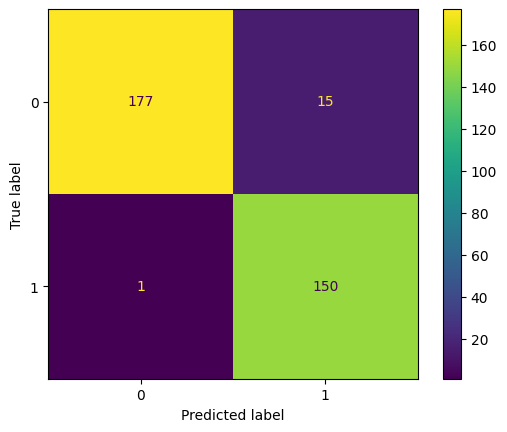

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_true, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


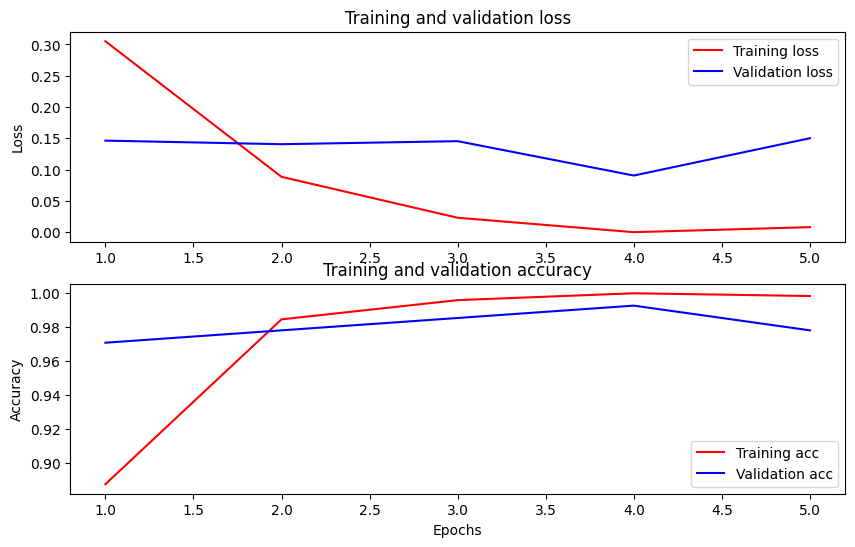

In [22]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [29]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open('BERT_history.json', 'w'))

In [ ]:
history_dict = history.history
ensemble_dict = ensemble_history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

ensemble_acc = ensemble_dict['binary_accuracy']
ensemble_val_acc = history_dict['val_binary_accuracy']
ensemble_loss = history_dict['loss']
ensemble_val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [24]:
dataset_name = '480_GPT_Initial_Study'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [27]:
unpickle = pickle.load(open('responses.pkl', 'rb'))
print(len(unpickle))


124


It's probably worth considering what would happen if we used PDF raw data -- the GPT generates very clean text; if we were to, say, obfuscate the text by putting it through a PDF it would make it much more realistic.